# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
- **Ревизия**: 6

- **Другие ревизии**: [ссылка](https://disk.yandex.ru/d/aZozDpBlzh_z1A)
<!-- please do not append text into this block -->

## 0. Изменения

**Модифицировано определение диагональной маски.** Строка в определении
метода `.backward()` класса `CustomReluFunction`:
```python
diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item()+1e-5)
```
заменена на:
```python
diagonal_mask = torch.diag(bernoulli_mask)
```

## 1. Настройки

In [25]:
## 1.1 Install dependencies

# pip install -r requirements.txt

In [26]:
## 1.2 Import library

import cgtnnlib.common as lib

## 5. Обучение

AttributeError: module 'cgtnnlib.common' has no attribute 'TrainingParameters'

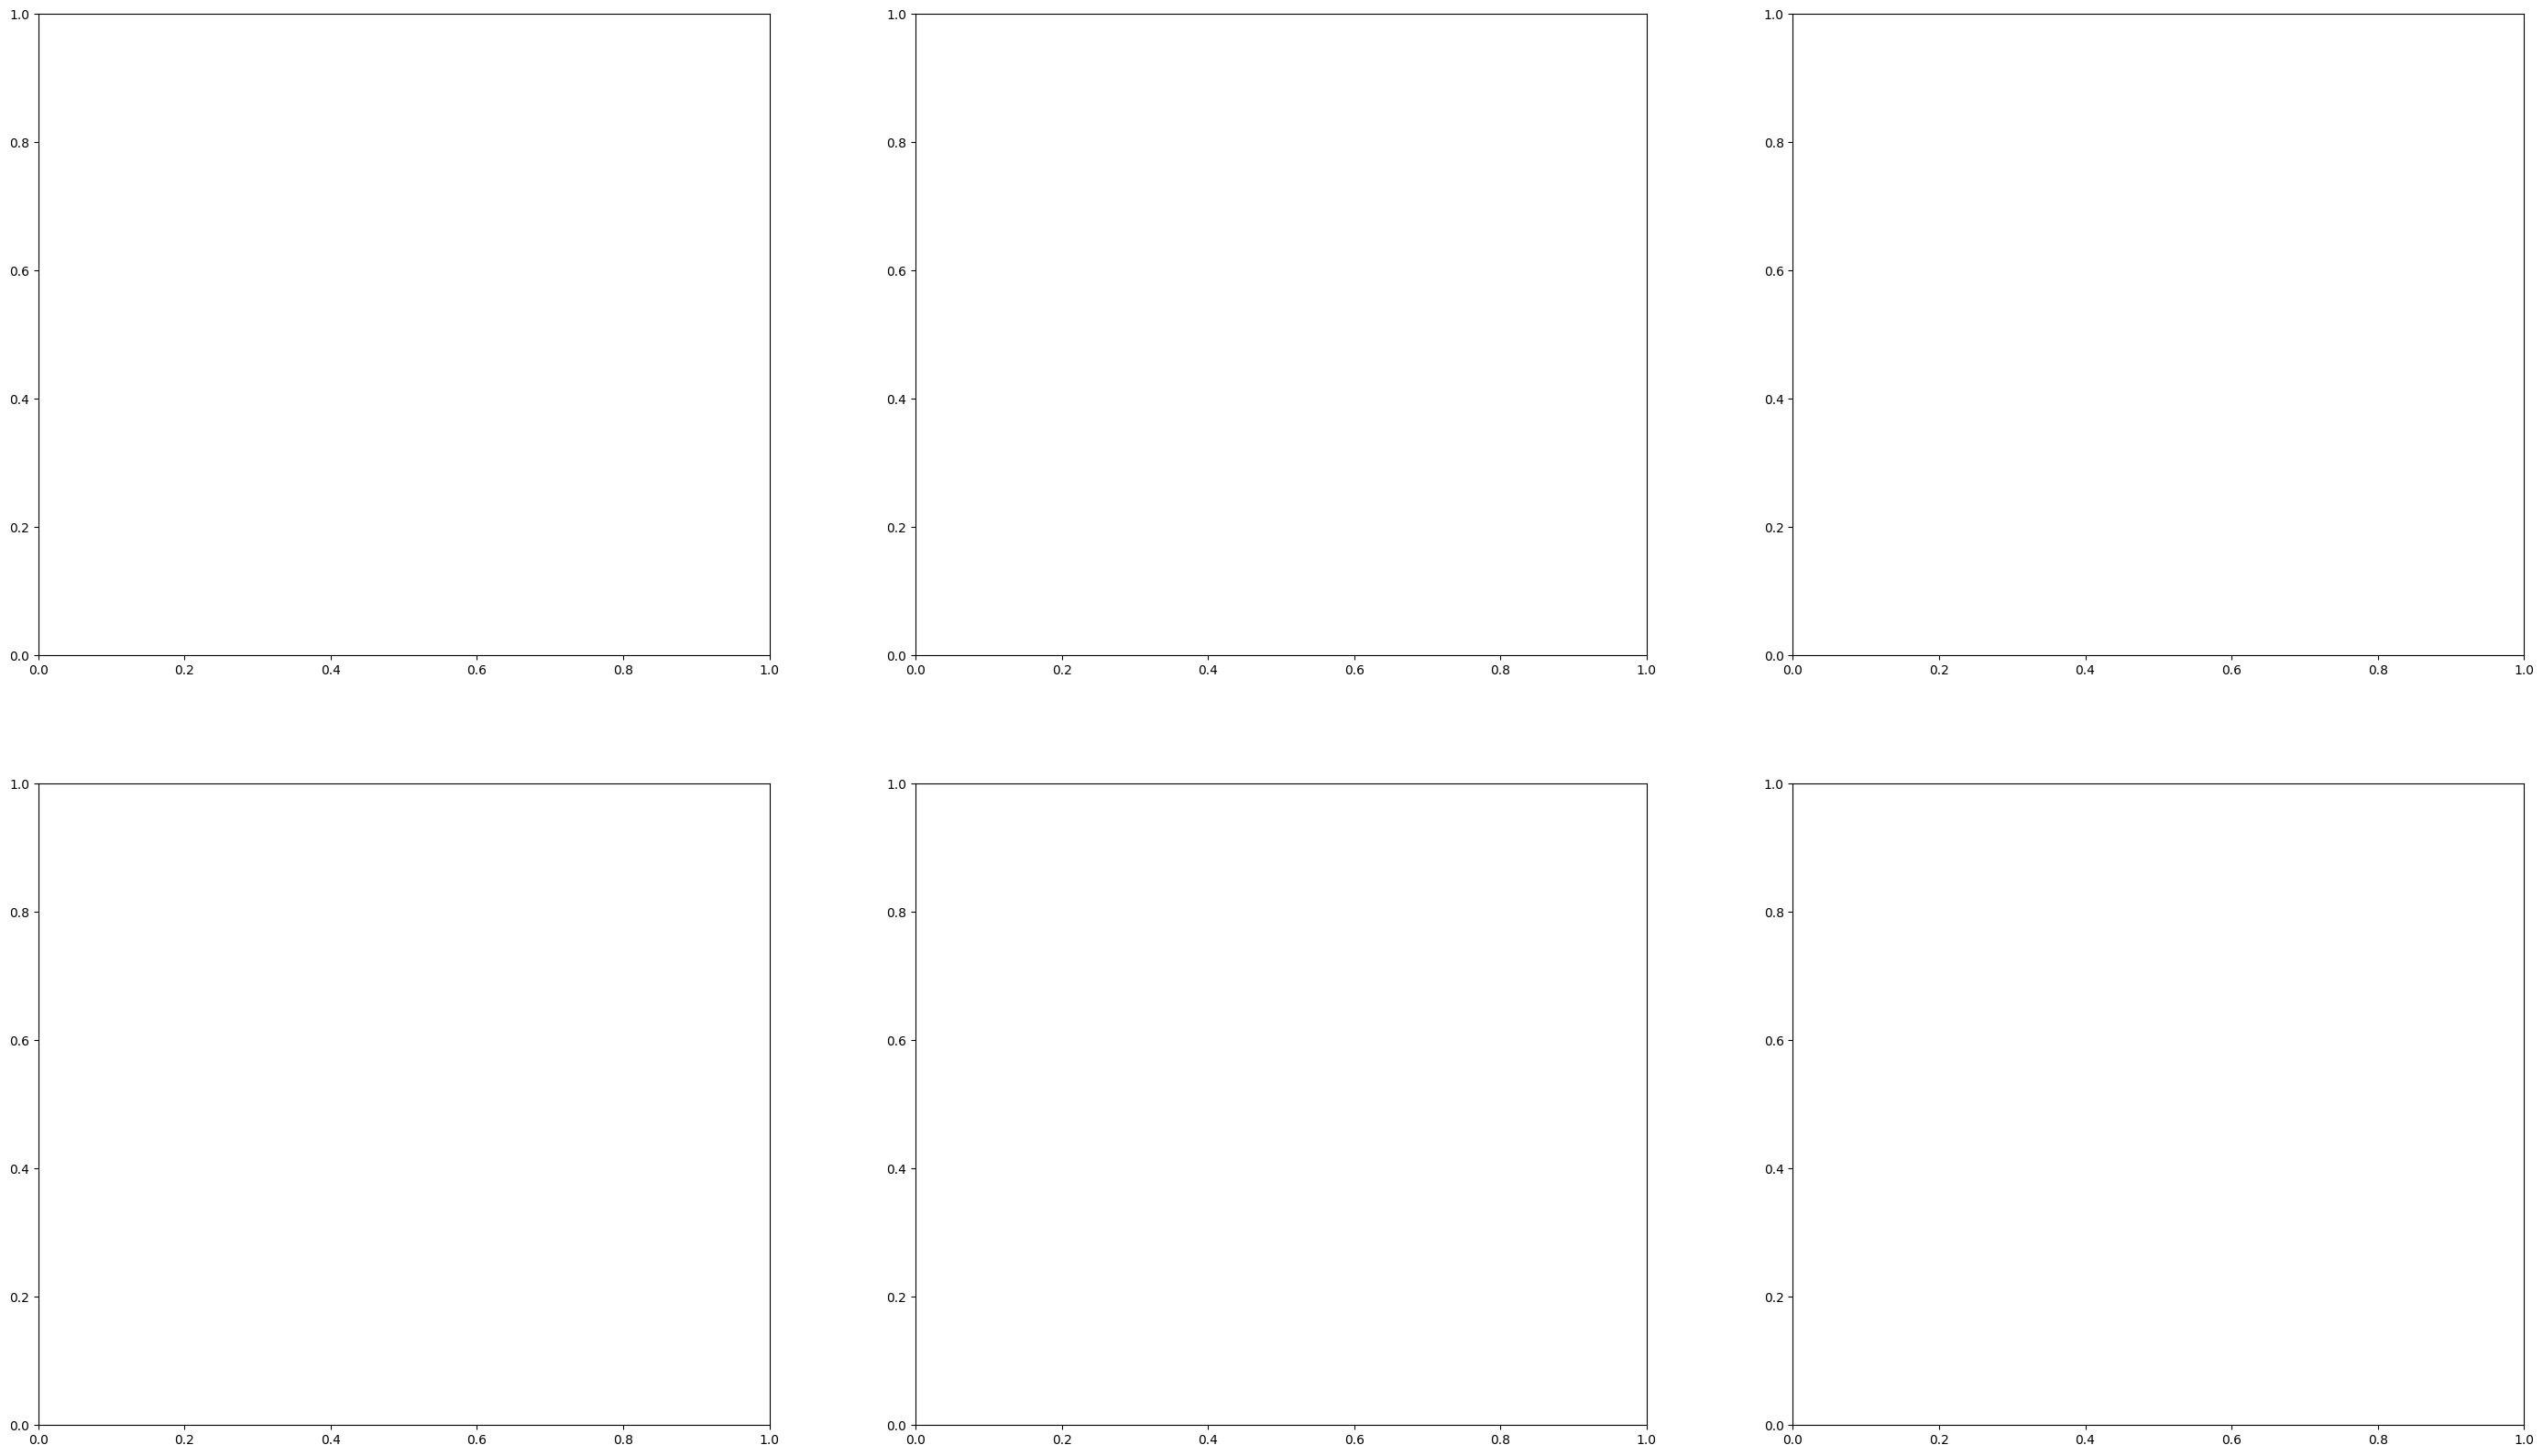

In [27]:
# 5.3. Training

import matplotlib.pyplot as plt
import torch

for experiment_params in lib.iterate_experiment_parameters():
    fig, axs = plt.subplots(2, 3, sharey='col', figsize=(10, 12))
    fig.set_size_inches(35, 20)

    for training_params in [
        lib.TrainingParameters(
            dataset=lib.DATASETS[0],
            criterion=lib.CLASSIFICATION_TASK.criterion,
            experiment_params=experiment_params,
            model_a_path=lib.DATASETS[0].model_a_path(experiment_params),
            model_b_path=lib.DATASETS[0].model_b_path(experiment_params),
            loss_curve_plot_col_index=0,
        ),
        lib.TrainingParameters(
            dataset=lib.DATASETS[1],
            criterion=lib.CLASSIFICATION_TASK.criterion,
            experiment_params=experiment_params,
            model_a_path=lib.DATASETS[1].model_a_path(experiment_params),
            model_b_path=lib.DATASETS[1].model_b_path(experiment_params),
            loss_curve_plot_col_index=1,
        ),
        lib.TrainingParameters(
            dataset=lib.DATASETS[2],
            criterion=lib.REGRESSION_TASK.criterion,
            experiment_params=experiment_params, 
            model_a_path=lib.DATASETS[2].model_a_path(experiment_params),
            model_b_path=lib.DATASETS[2].model_b_path(experiment_params),
            loss_curve_plot_col_index=2,
        )
    ]:
        inputs_count = training_params.dataset.features_count
        outputs_count = training_params.dataset.classes_count

        for (model, name, row) in [
            (lib.RegularNetwork(
                inputs_count=inputs_count,
                outputs_count=outputs_count,
                p=experiment_params.p
            ), training_params.model_a_path, 0),
            (lib.AugmentedReLUNetwork(
                inputs_count=inputs_count,
                outputs_count=outputs_count,
                p=experiment_params.p
            ), training_params.model_b_path, 1)
        ]:
            model.apply(lib.init_weights)
            
            model = model.to(lib.device)
            
            running_losses = lib.train(
                model=model,
                dataset=training_params.dataset,
                epochs=lib.EPOCHS,
                experiment_parameters=experiment_params,
                criterion=training_params.criterion,
                optimizer=lib.optim.Adam(
                    model.parameters(),
                    lr=lib.LEARNING_RATE
                )
            )
            
            torch.save(model.state_dict(), name)
            
            report_key = f'loss_{type(model).__name__}_{training_params.dataset.number}_p{experiment_params.p}_N{experiment_params.iteration}'
            
            lib.append_to_report(report_key, running_losses)
            
            col = training_params.loss_curve_plot_col_index

            lib.plot_loss_curve(
                ax=axs[row, col],
                model_name=model.__class__.__name__,
                dataset_name=training_params.dataset.name,
                dataset_number=training_params.dataset.number,
                running_losses=running_losses,
                p=experiment_params.p,
                iteration=experiment_params.iteration
            )
    
    path = lib.save_plot(f'loss__p{experiment_params.p}_N{experiment_params.iteration}')

print("Done!")

In [ ]:
lib.save_report()

Отчёт сохранён в report/report.json


## 6. Валидация 

In [ ]:
# 6.2. Evaluation

from dataclasses import dataclass

@dataclass
class EvaluationParameters:
    dataset: lib.Dataset
    model_path: str
    is_binary_classification: bool
    is_regression: bool
    inputs_count: int
    outputs_count: int
    task: lib.LearningTask
    experiment_parameters: lib.ExperimentParameters
    report_key: str


def model_path_for(
    model_a_or_b: str,
    dataset: lib.Dataset
):
    if model_a_or_b == 'A':
        return dataset.model_a_path(experiment_params)
    elif model_a_or_b == 'B':
        return dataset.model_b_path(experiment_params)
    else:
        raise TypeError('model_a_or_b must be A or B')

def evaluate(
    model_a_or_b: str,
    constructor: type,
    experiment_params: EvaluationParameters
):
    """
    Оценивает модель `"A"` (`RegularNetwork`) или `"B"`
    (`AugmentedReLUNetwork`) согласно параметрам `experiment_params` на
    наборах данных из `DATASETS`.
    Рисует графики метрик в `subplots`.
    
    - `constructor` может быть `RegularNetwork` или `AugmentedReLUNetwork`
      и должен соответствовать переданному `model_a_or_b`.
    """
    

    eval_params_items: list[EvaluationParameters] = [
        EvaluationParameters(
            dataset=lib.DATASETS[0],
            model_path=model_path_for(model_a_or_b, lib.DATASETS[0]),
            is_binary_classification=True,
            is_regression=False,
            inputs_count=30,
            outputs_count=2,
            task=lib.CLASSIFICATION_TASK,
            experiment_parameters=experiment_params,
            report_key=f'evaluate_{constructor.__name__}_{lib.DATASETS[0].number}_p{experiment_params.p}_N{experiment_params.iteration}',
        ),
        EvaluationParameters(
            dataset=lib.DATASETS[1],
            model_path=model_path_for(model_a_or_b, lib.DATASETS[1]),
            is_binary_classification=False,
            is_regression=False,
            inputs_count=6,
            outputs_count=4,
            task=lib.CLASSIFICATION_TASK,
            experiment_parameters=experiment_params,
            report_key=f'evaluate_{constructor.__name__}_{lib.DATASETS[1].number}_p{experiment_params.p}_N{experiment_params.iteration}',
        ),
        EvaluationParameters(
            dataset=lib.DATASETS[2],
            model_path=model_path_for(model_a_or_b, lib.DATASETS[2]),
            is_binary_classification=False,
            is_regression=True,
            inputs_count=19,
            outputs_count=1,
            task=lib.REGRESSION_TASK,
            experiment_parameters=experiment_params,
            report_key=f'evaluate_{constructor.__name__}_{lib.DATASETS[2].number}_p{experiment_params.p}_N{experiment_params.iteration}',
        ),
    ]

    fig, axs = plt.subplots(3, len(eval_params_items), figsize=(10, 12))
    fig.set_size_inches(35, 20)

    for (i, eval_params) in enumerate(eval_params_items):
        evaluated_model = constructor(
            inputs_count=eval_params.inputs_count,
            outputs_count=eval_params.outputs_count,
            p=experiment_params.p
        )

        lib.clear_output(wait=True)
        print(f'Evaluating model at {eval_params.model_path}...')
        evaluated_model.load_state_dict(torch.load(eval_params.model_path))

        plot_title = f'Evaluating {eval_params.model_path}: p = {eval_params.experiment_parameters.p}, N = {eval_params.experiment_parameters.iteration}'
        
        subplots = lib.EvaluationSubplots(
            accuracy_ax=axs[0, i],
            f1_ax=axs[1, i],
            roc_auc_ax=axs[2, i],
            mse_ax=axs[0, i],
            r2_ax=axs[1, i],
        )
    
        if eval_params.task == lib.CLASSIFICATION_TASK:
            lib.plot_evaluation_of_classification(
                df=lib.evaluate_classification_model(
                    evaluated_model=evaluated_model,
                    dataset=eval_params.dataset,
                    report_key=eval_params.report_key,
                    is_binary_classification=eval_params.is_binary_classification
                ),
                accuracy_ax=subplots.accuracy_ax,
                f1_ax=subplots.f1_ax,
                roc_auc_ax=subplots.roc_auc_ax,
                title=plot_title
            )
        elif eval_params.task == lib.REGRESSION_TASK:
            lib.plot_evaluation_of_regression(
                df=lib.evaluate_regression_model(
                    evaluated_model=evaluated_model,
                    dataset=eval_params.dataset,
                    report_key=eval_params.report_key
                ),
                mse_ax=subplots.mse_ax,
                r2_ax=subplots.r2_ax,
                title=plot_title
            )
        else:
            raise ValueError(f"Unknown task: {eval_params.task}")

    lib.save_plot(f'evaluate_{model_a_or_b}_p{experiment_params.p}_N{experiment_params.iteration}')


for experiment_params in lib.iterate_experiment_parameters():
    evaluate(
        model_a_or_b='A',
        constructor=lib.RegularNetwork,
        experiment_params=experiment_params
    )
    evaluate(
        model_a_or_b='B',
        constructor=lib.AugmentedReLUNetwork,
        experiment_params=experiment_params
    )

lib.save_report()
print("Done!")

Evaluating model at pth/model-3B-c-P0.99_N9.pth...
Отчёт сохранён в report/report.json
Done!


## 7. Анализ данных

In [ ]:
# 1. Загрузка отчёта

import json

with open('./report/report.json') as fd:
    report = json.load(fd)

In [ ]:
# 2. Составление индекса для поиска по отчёту

import pandas as pd

df = pd.DataFrame([[key] + key.split('_') for key in report.keys()])
df.columns = ['Key', 'Measurement', 'Network', 'Dataset', 'P', 'N']
df.Dataset = df.Dataset.apply(lambda x: int(x))
df.P = df.P.apply(lambda x: float(x[1:]))
df.N = df.N.apply(lambda x: int(x[1:]))
df

,Key,Measurement,Network,Dataset,P,N
0,loss_RegularNetwork_1_p0_N0,loss,RegularNetwork,1,0.00,0
1,loss_AugmentedReLUNetwork_1_p0_N0,loss,AugmentedReLUNetwork,1,0.00,0
2,loss_RegularNetwork_2_p0_N0,loss,RegularNetwork,2,0.00,0
3,loss_AugmentedReLUNetwork_2_p0_N0,loss,AugmentedReLUNetwork,2,0.00,0
4,loss_RegularNetwork_3_p0_N0,loss,RegularNetwork,3,0.00,0
...,...,...,...,...,...,...
835,evaluate_RegularNetwork_2_p0.99_N9,evaluate,RegularNetwork,2,0.99,9
836,evaluate_RegularNetwork_3_p0.99_N9,evaluate,RegularNetwork,3,0.99,9
837,evaluate_AugmentedReLUNetwork_1_p0.99_N9,evaluate,AugmentedReLUNetwork,1,0.99,9
838,evaluate_AugmentedReLUNetwork_2_p0.99_N9,evaluate,AugmentedReLUNetwork,2,0.99,9


In [ ]:
# 3. Вывод графиков

import os
from dataclasses import dataclass

import matplotlib.pyplot as plt
import pandas as pd

@dataclass
class PlotParams:
    measurement: str
    dataset: int
    network = 'AugmentedReLUNetwork'
    metric: str
    p: int
    
def compute_dataframe(plot_params: PlotParams) -> pd.DataFrame:
    rows = (
        df
            .loc[df.Measurement == plot_params.measurement]
            .loc[df.Dataset == plot_params.dataset]
            .loc[df.Network == plot_params.network]
            .loc[df.P == plot_params.p]
    )

    if plot_params.measurement == 'loss':
        values = pd.DataFrame([report[row.Key] for row in rows.itertuples()])
    else:
        cols = []
        
        for row in rows.itertuples():
            report_data = report[row.Key]
            cols.append(report_data[plot_params.metric])
            
        values = pd.DataFrame(cols)

    result = values.quantile([0.25, 0.75]).transpose()
    result['mean'] = values.mean()
    return result


def plot_curve(
    ax: object,
    means: pd.Series,
    lowerqs: pd.Series,
    upperqs: pd.Series,
    zmeans: pd.Series,
    zlowerqs: pd.Series,
    zupperqs: pd.Series,
    X: pd.Series,
    title: str,
    xlabel: str,
    ylabel: str,
):
    ax.plot(X, zmeans, label='Mean of p = 0', color='lightblue')
    ax.fill_between(X, zlowerqs, zupperqs, color='lightgray', alpha=0.5, label='0.25 to 0.75 Quantiles, p = 0')
    ax.plot(X, means, label='Mean', color='blue')
    ax.fill_between(X, lowerqs, upperqs, color='gray', alpha=0.5, label='0.25 to 0.75 Quantiles')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()


for (measurement, dataset, xlabel) in [
    ('loss', 1, 'iteration'),
    ('evaluate', 1, 'noise factor'),
    ('loss',  2, 'iteration'),
    ('evaluate', 2, 'noise factor'),
    ('loss', 3, 'iteration'),
    ('evaluate', 3, 'noise factor'),
]:
    if measurement == 'loss':
        metrics = ['loss']
    else:
        if dataset == 3:
            metrics = ['r2', 'mse']
        else:
            metrics = ['f1', 'accuracy', 'roc_auc']
    
    fig, axs = plt.subplots(len(metrics), 6, figsize=(24, len(metrics) * 6))
    for (i, metric) in enumerate(metrics):
        reference_curve = compute_dataframe(plot_params=PlotParams(
            measurement=measurement,
            dataset=dataset,
            metric=metric,
            p=0,
        ))

        for (j, p) in enumerate([0.01, 0.05, 0.5, 0.9, 0.95, 0.99]):
            plot_params=PlotParams(
                measurement=measurement,
                dataset=dataset,
                metric=metric,
                p=p,
            )

            curve=compute_dataframe(plot_params=plot_params)
            plot_curve(
                ax=axs[i, j] if len(metrics) > 1 else axs[j],
                means=curve['mean'],
                lowerqs=curve[0.25],
                upperqs=curve[0.75],
                zmeans=reference_curve['mean'],
                zlowerqs=reference_curve[0.25],
                zupperqs=reference_curve[0.75],
                X=curve.index,
                title=f'p = {plot_params.p}',
                xlabel=xlabel,
                ylabel=metric,
            )
    fig.suptitle(f'Dataset #{plot_params.dataset}')
    plt.tight_layout()
    path = os.path.join('report/', f'{measurement}_{dataset}.png')
    plt.savefig(path)
    plt.close()